# Matter power spectrum $P(k,z)$ from theory (CAMB) to observations

## Import libraries and modules, check CAMB version

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})

import numpy as np

from astropy.cosmology import Planck18 # Planck 2018 cosmology, see https://arxiv.org/abs/1807.06209
import astropy.units as au # Astrophysical units

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.4.0 installed at /usr/local/anaconda/envs/py311forge/lib/python3.11/site-packages/camb


## Specify cosmology

### We can specify our own cosmology or read from an ini file, in this case we read cosmology the Planck 2018 base $\Lambda$CDM constraint

In [99]:
pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
print(pars)

class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_both
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 1.3464234
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2700
 max_l_tensor = 600
 max_eta_k = 18000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0223828
 omch2 = 0.1201075
 omk = 0.0
 omnuh2 = 0.0006451439
 H0 = 67.32117
 TCMB = 2.7255
 YHe = 0.2454006
 num_nu_massless = 2.046
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = True
 nu_mass_degeneracies = [0.0]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_indeptilt
   ns = 0.9660499
   nrun = 0.0
   nrunrun = 0.0
 

### If you want to further adjust cosmological parameter(s), you can do so here

In [95]:
## Better to set values for all varying cosmological parameters in the same place
#H0=
#omch2=
#ombh2=
#omk=
#mnu=
#tau=
#As=
#ns=
#r=0.

## Set parameters control the homogeneous background universe
#pars.set_cosmology(H0=,ombh2=,omch2=,omk=,mnu=,tau=)

## Set parameters control the inhomogeneous universe, i.e. the primordial perturbations
#pars.InitPower.set_params(As=, ns=, r=)

## Check and understand CAMB theoretical prediction

### Set some parameter range

In [100]:
redshift_snaphots=[1.,0.]
kmin=1e-4
kmax=2.0
nr_k_points=200
pars.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Compute theoretical prediction for $P(k,z)$ from CAMB

In [101]:
results = camb.get_results(pars) # invoke CAMB to solve the coupled Boltzmann equations for perturbations and get the results
# Note here that technically we output the nonlinear P(k), i.e. linear P(k) with corrections to account for nonlinear evolutions
kh, z, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = nr_k_points)

### Visualize results

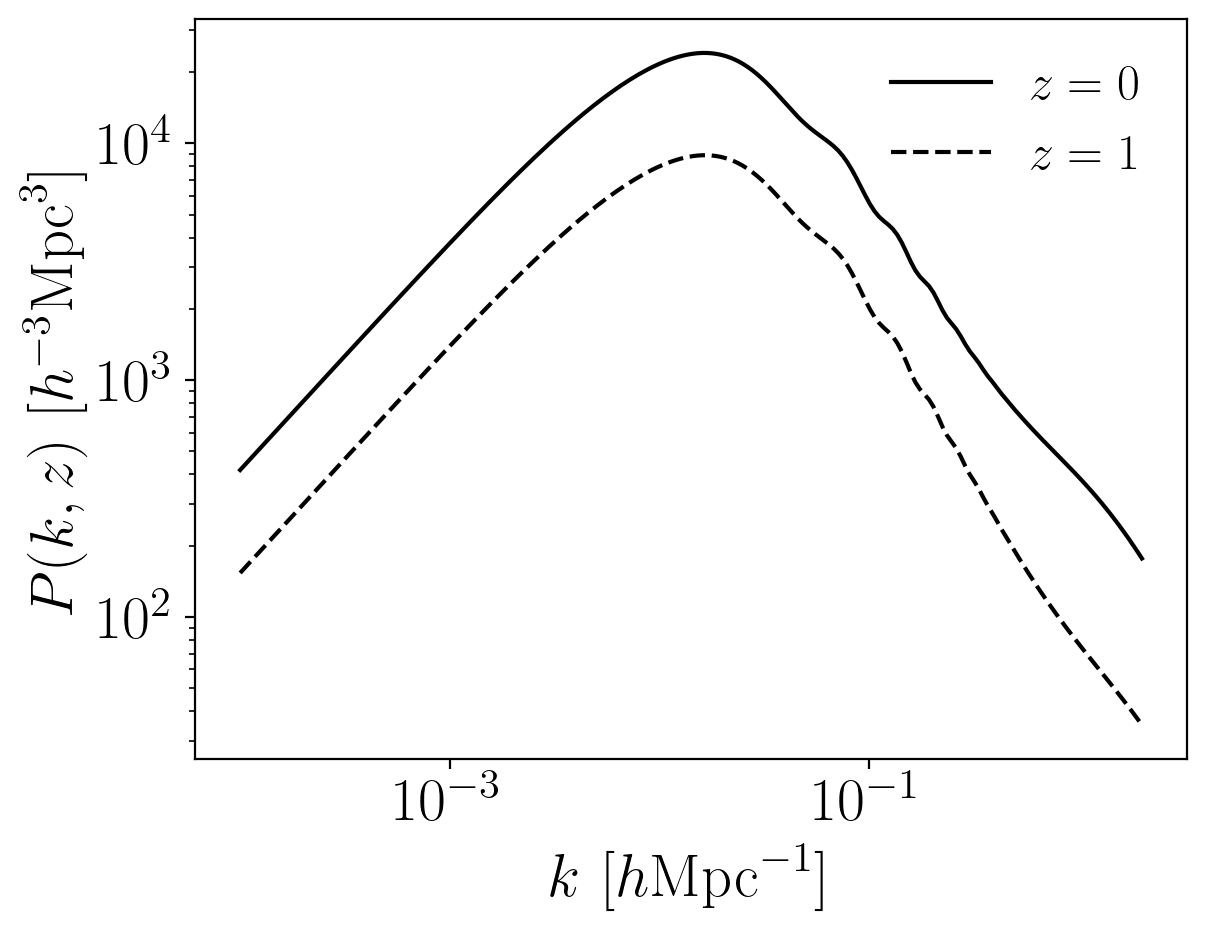

In [102]:
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_nonlin[i,:], color='k', ls = line, label=r'$z=%d$'%i)
ax.set_xlabel(r'$k\,\,[h\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k,z)\,\,[h^{-3}\mathrm{Mpc}^3]$')
ax.legend(frameon=False,fontsize=18);

## Connection to observations - Cosmic variance and shot noise

### Cosmic variance

Within each range of Fourier mode (wavenumber) $k=|\vec{k}|$ , there is a finite number of Fourier modes $N_{\mathrm{modes}}(k)$. The precise numbers depend on the fundamental Fourier mode, the lowest mode probed by the survey $k_F=2\pi/L$, where $L$ denotes the side length of the box if you imagine encapsulating the survey into a cubic volume.

Therefore at each $k$, the we effectively measure or estimate $\bar{P}(k)$ from $N_{\mathrm{modes}}(k)$ samples.

### Shot noise

When we measure $P(k)$ in simulations or observations, we use some discrete tracers to sample/represent the underlying continous matter density field $\delta_m(k)$. Due to the discrete nature, they introduce Poisson shot noise into the $\bar{P}(k)$ estimator:

$$\bar{P}(k)=P(k)+P_{\mathrm{shotnoise}}$$,

where it is often *assumed* that $P_{\mathrm{shotnoise}}=,$ with $n_{\mathrm{tracer}}=$ being the tracer volume density.

### Putting things together, (CAMB) theoretical prediction with observational error bars

## Measure $P(k)$ from a simulation